Speech Tokenizer Codec: https://github.com/ZhangXInFD/SpeechTokenizer

In [3]:
#Extracting discrete representations
import torchaudio
import torch
import os
current_dir = os.getcwd()

# audio file_path
file_path = os.path.join(current_dir, "sample_9.wav")

# Load and pre-process speech waveform
wav, sr = torchaudio.load(file_path)

print(wav.shape)


torch.Size([1, 441000])


In [1]:
from speechtokenizer import SpeechTokenizer

config_path = '/data/lekha_codec_model_files/config.json'
ckpt_path = '/data/lekha_codec_model_files/SpeechTokenizer.pt'
model = SpeechTokenizer.load_from_checkpoint(config_path, ckpt_path)
model.eval()

/home/lekhab/.conda/envs/codec_fake/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lekhab/.conda/envs/codec_fake/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/home/lekhab/.conda/envs/codec_fake/lib/python3.12/site-packages/speechtokenizer/model.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default va

SpeechTokenizer(
  (encoder): SEANetEncoder(
    (model): Sequential(
      (0): SConv1d(
        (conv): NormConv1d(
          (conv): Conv1d(1, 64, kernel_size=(7,), stride=(1,))
          (norm): Identity()
        )
      )
      (1): SEANetResnetBlock(
        (block): Sequential(
          (0): ELU(alpha=1.0)
          (1): SConv1d(
            (conv): NormConv1d(
              (conv): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
              (norm): Identity()
            )
          )
          (2): ELU(alpha=1.0)
          (3): SConv1d(
            (conv): NormConv1d(
              (conv): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
              (norm): Identity()
            )
          )
        )
        (shortcut): SConv1d(
          (conv): NormConv1d(
            (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
            (norm): Identity()
          )
        )
      )
      (2): ELU(alpha=1.0)
      (3): SConv1d(
        (conv): NormConv1d(
          (conv):

In [4]:
# monophonic checking
if wav.shape[0] > 1:
    wav = wav[:1,:]

if sr != model.sample_rate:
    wav = torchaudio.functional.resample(wav, sr, model.sample_rate)

wav = wav.unsqueeze(0)

# Extract discrete codes from SpeechTokenizer
with torch.no_grad():
    codes = model.encode(wav) # codes: (n_q, B, T)

RVQ_1 = codes[:1, :, :] # Contain content info, can be considered as semantic tokens
RVQ_supplement = codes[1:, :, :] # Contain timbre info, complete info lost by the first quantizer

In [9]:
print(RVQ_1.shape)
print(RVQ_supplement.shape)

torch.Size([1, 1, 500])
torch.Size([7, 1, 500])


In [11]:
import torchaudio

# Combine RVQ_1 and RVQ_supplement back into the full codes
reconstructed_codes = torch.cat([RVQ_1, RVQ_supplement], dim=0)

# Reconstruct waveform from the discrete codes
with torch.no_grad():
    reconstructed_wav = model.decode(reconstructed_codes)

# The `reconstructed_wav` will have shape (B, T)
# Save the reconstructed waveform as an audio file
output_path = os.path.join(current_dir, "speech_tokenizer_reconstructed.wav")

# Ensure the waveform is in a valid range for audio (e.g., [-1.0, 1.0])
reconstructed_wav = reconstructed_wav.squeeze(0).clamp(-1.0, 1.0)

# Save using torchaudio
torchaudio.save(output_path, reconstructed_wav, model.sample_rate)

print(f"Reconstructed audio saved to {output_path}")


Reconstructed audio saved to /home/lekhab/AudioDeepfake/speech_tokenizer_reconstructed.wav


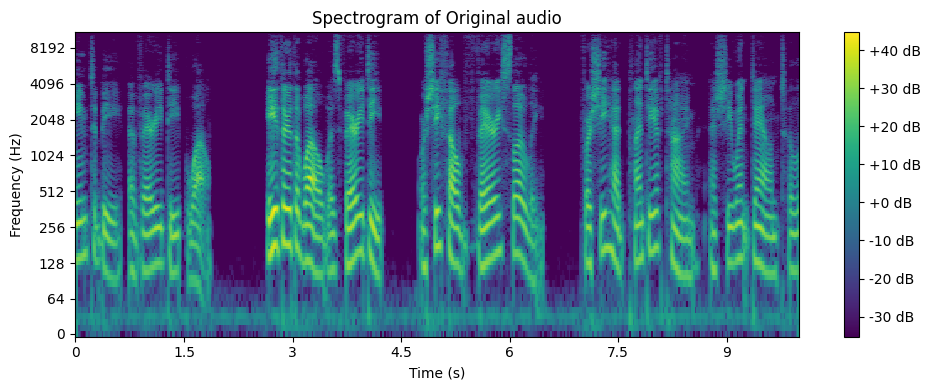

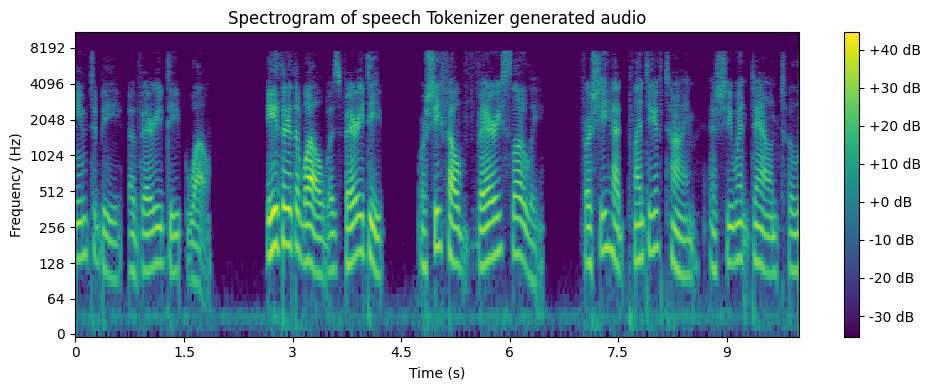

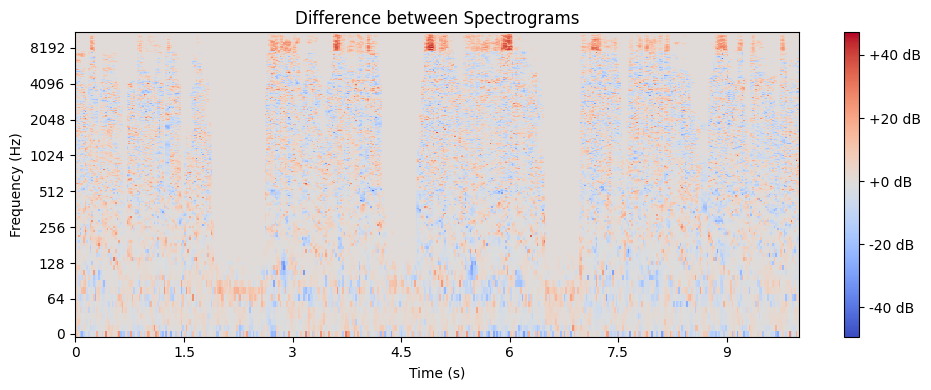

In [13]:
#Create spectograms for input and output audio files

import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot_spectrogram(audio_file, title):
    # Load the audio file
    y, sr = librosa.load(audio_file)
    
    # Compute the STFT and convert to decibel scale
    stft = librosa.stft(y)
    spectrogram = librosa.amplitude_to_db(abs(stft))
    
    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()



def plot_spectrogram_difference(audio_file1, audio_file2):
    # Load and compute spectrograms for both audio files
    y1, sr1 = librosa.load(audio_file1)
    y2, sr2 = librosa.load(audio_file2)
    
    if sr1 != sr2:
        raise ValueError("Sample rates of the two audio files do not match. Please resample to the same rate.")
    
    # Compute the STFT for both signals
    stft1 = librosa.stft(y1)
    stft2 = librosa.stft(y2)
    
    # Convert to decibel scale
    spectrogram1 = librosa.amplitude_to_db(abs(stft1))
    spectrogram2 = librosa.amplitude_to_db(abs(stft2))
    
    # Compute the difference between the two spectrograms
    spectrogram_diff = spectrogram1 - spectrogram2
    
    # Plot the difference
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_diff, sr=sr1, x_axis='time', y_axis='log', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Difference between Spectrograms")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()
# File paths for the two audio files
audio_file1 = 'sample_9.wav'  # original audio
audio_file2 = 'speech_tokenizer_reconstructed.wav'  # output audio file from dac

# Plot spectrograms for both files
plot_spectrogram(audio_file1, title="Spectrogram of Original audio")
plot_spectrogram(audio_file2, title="Spectrogram of speech Tokenizer generated audio")
plot_spectrogram_difference(audio_file1, audio_file2)